In [1]:
import pandas as pd
import numpy as np
import pickle
import joblib
### 모델링--------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, accuracy_score, roc_auc_score
# 업샘플링
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
### 새로운 데이터 --------------------
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.preprocessing import LabelEncoder
### x 만들기 -----------------------
# 지오코딩
!pip install pandas openpyxl
!pip install geokakao
import geokakao as gk
# 역지오코딩
import requests
import re
# 배수등급, 경사도
import geopandas as gpd
from shapely.geometry import Point
### XAI ----------------------------
import shap
from scipy.special import inv_boxcox
# 시각화
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False
import matplotlib.font_manager as fm
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,005 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and dire

In [2]:
### 모델 불러오기
model_path = '/content/drive/MyDrive/준희/Modeling/Prediction/xgb_model_wo_env.pkl'
xgb_model = joblib.load(model_path)

### 기존 데이터

In [3]:
### 데이터 불러오기
pothole = pd.read_csv('/content/drive/MyDrive/DATA_완성/pothole_예측용.csv')
pothole['발생여부'] = np.where(pothole['포트홀 갯수'] >=1, 1, 0)

### x, y 할당
x = pothole[['차선수', '승용차', '버스', '트럭', '평균_건물연령', '인구 수', '배수등급', '경사도']] ########## 날씨 제외하고
y = pothole['발생여부']

### train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify = y, random_state = 1384)

### SMOTE
smote = SMOTE(random_state = 1392)
x_train_up, y_train_up = smote.fit_resample(x_train, y_train)

In [4]:
x_train_up.to_csv("/content/drive/MyDrive/준희/Report/x_train_up.csv", encoding = "utf-8-sig")
y_train_up.to_csv("/content/drive/MyDrive/준희/Report/y_train_up.csv", encoding = "utf-8-sig")
x_test.to_csv("/content/drive/MyDrive/준희/Report/x_test.csv", encoding = "utf-8-sig")
y_test.to_csv("/content/drive/MyDrive/준희/Report/y_test.csv", encoding = "utf-8-sig")

In [ ]:
### x_test로 predict
y_pred = xgb_model.predict(x_test)
y_pred_prob = xgb_model.predict_proba(x_test)[:, -1]
original_predicted = pd.DataFrame({'예측' : y_pred, '예측 확률' : y_pred_prob})
original_predicted[:5]

,예측,예측 확률
0,1,0.549750
1,1,0.709045
2,0,0.356091
3,1,0.986444
4,0,0.194440


#### SHAP - 변수 기여도 파악

In [ ]:
### SHAP
shap_explainer = shap.Explainer(xgb_model, x_train_up)
shap_values_ex = shap_explainer(x_test) # 각 SHAP value에 대한 정보를 담은 Explainer
# Explainer 살펴보기
print("SHAP values 크기 : ", np.array(shap_values_ex).shape) # (# x_test 데이터, # 변수들)

 97%|=================== | 4524/4644 [00:19<00:00]       

SHAP values 크기 :  (4644, 8)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

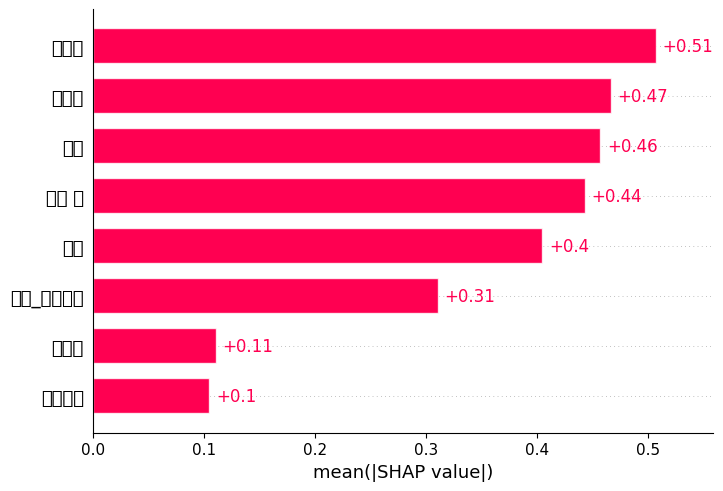

In [ ]:
# 전체 feature importance
shap.plots.bar(shap_values_ex)

- 설명
  - 전체 변수들의 기여도를 절댓값으로 표현한 것
  - 방향성은 아직 모르고, 기여도 정도만 알 수 있음!

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


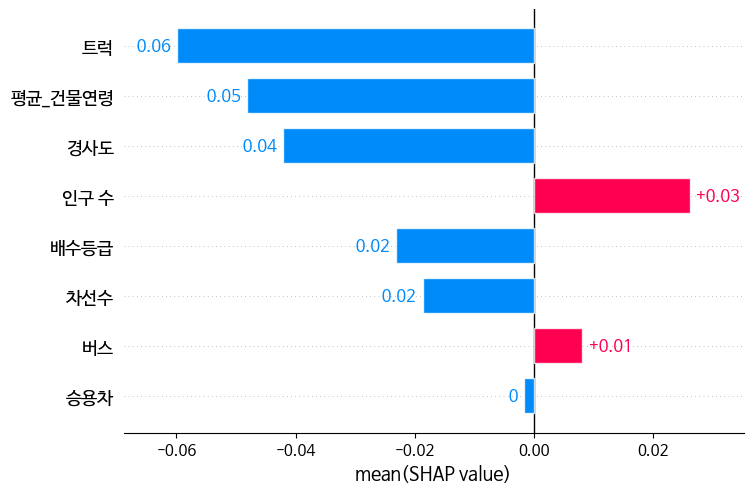

In [ ]:
# 평균 feature importance
shap.plots.bar(shap_values_ex.mean(axis = 0))

- 해석
  - 빨강으로 표현된 변수들이 y=1 로 예측되게끔 했고,
  - 파랑으로 표현된 변수들이 y=0 으로 예측되게끔 했다
- 위랑 순서가 다른 이유는..?
  - 위에서는 '중요도'만 보고 판단해서 나오는 거고, 여기서는 '방향, 크기'를 보고 판단하는 거라 둘이 다르대!
  - 전반적인 '중요도'랑 'y=1로 끌어오는 애'는 다르니까

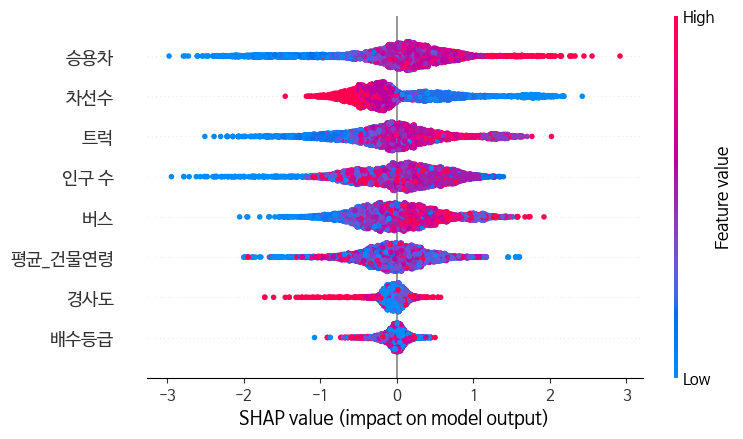

In [ ]:
# 전체 분포 (beeswarm)
shap.plots.beeswarm(shap_values_ex)

- 해석
  - 각 변수들의 값이 증가할 때 (파랑 -> 빨강) SHAP value들의 변화를 파악할 수 있음
  - 승용차 변수의 값이 증가하면 => SHAP value 도 늘어나니까 y=1으로 만든다! 는 의미

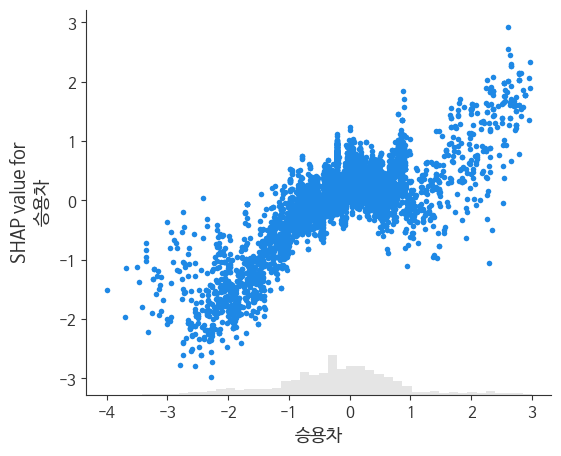

In [ ]:
# 특정 feature 하나 (scatter)
shap.plots.scatter(shap_values_ex[:, "승용차"])

- `승용차` 변수의 기여도 파악
  - `승용차` 변수의 값이 증가할 수록 y=1일 가능성이 높아진다~

/usr/local/lib/python3.11/dist-packages/shap/plots/_waterfall.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  text_bbox = txt_obj.get_window_extent(renderer=renderer)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


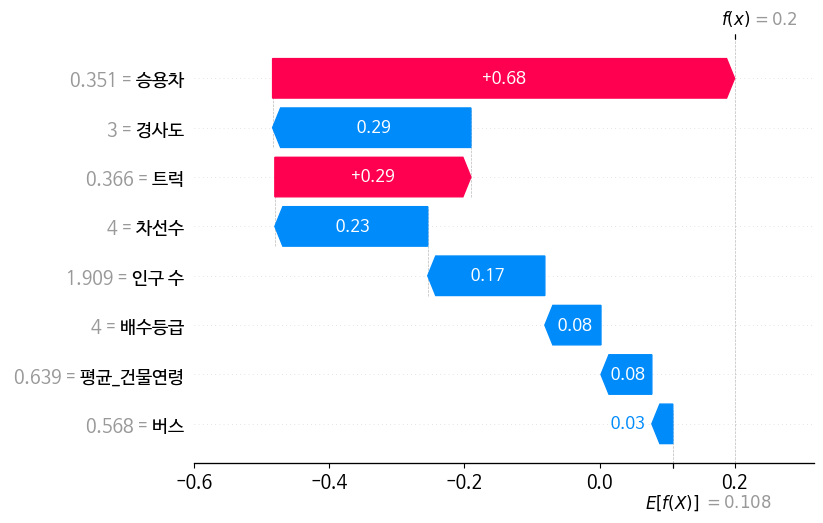

In [ ]:
# 특정 샘플 설명 - 0번째 샘플에 대한 각 변수들의 기여도
shap.plots.waterfall(shap_values_ex[0])

In [ ]:
x_test.iloc[0, :]

,10533
차선수,4.000000
승용차,0.351428
버스,-0.567919
트럭,0.365851
평균_건물연령,-0.638833
인구 수,1.908634
배수등급,4.000000
경사도,3.000000


- 해석
  - data point 하나에 대한 local explainer
  - 왼쪽의 값들은 0번째 데이터의 실제 데이터 값
  - 0번째 데이터에 대해 y = 1으로 분류되었을 때..
    - baseline = 0.108
    - 밑에서부터 -0.03, -0.08, -0.08... 쭉쭉 가다 보면
    - 마지막 지점이 0.2가 돼서 y = 1로 분류
----
- 확률값의 의미
  - 그래프의 확률 = 0.2 는 log-odds의 값이다!
  - 즉, 그래프 상 확률이 0이 되어야지 `pred_prob`에서 0.5가 되는 지점인 것
  - 여기서는 0.2로 0보다 크니까 `pred_prob`이 y = 1 쪽으로 기우는 것!!!

In [ ]:
print(f"XAI로 계산한 prob : {1/(1+np.exp(-0.2)):.5f}")
print(f"모델로 파악한 prob : {y_pred_prob[0]:.5f}")

XAI로 계산한 prob : 0.54983
모델로 파악한 prob : 0.54975


### 새로운 데이터

In [ ]:
### Input - 주의 : 행정동이 명시적으로 존재해야
input = ["서울특별시 강남구 대치동 507",
         "서울특별시 동대문구 제기동 137-418",
         "서울특별시 서대문구 홍은동 9-360",
         "서울특별시 영등포구 당산1동 당산로 31길 25",
         "서울특별시 서초구 방배동 756-4",
         "서울특별시 용산구 동빙고동 90-1",
         "서울특별시 성북구 보문동5가 235",
         "서울특별시 노원구 공릉2동 29-4"]
date = ['2024-07-28', '2023-06-23', '2022-05-21', '2023-12-05', '2021-10-29', '2024-01-05', '2022-04-29', '2021-02-03']
new_data = pd.DataFrame({'날짜' : date, '주소' : input})

#### x 만들기

##### 함수들 정의

In [ ]:
### ----------------------------------------------------------------------------------

def geo_coding(df):
    ### 위도, 경도
    gk.add_coordinates_to_dataframe(df, '주소')
    df = df.rename(columns = {"decimalLatitude" : "위도", "decimalLongitude" : "경도"})

    ### 자치구, 행정동
    # 동 : ~동, ~가 부분 찾아오기
    def get_dong(address):
        find = re.search(r"\b(\w+[동가])\b", address)
        if find:
            dong = find.group(1)
            return(dong)
        else:
            return(np.nan)

    # 구 : ~구 부분 찾아오기
    def get_gu(address):
        find = re.search(r"\b(\w+구)\b", address)
        if find:
            gu = find.group(1)
            return(gu)
        else:
            return(np.nan)

    # DataFrame 추가
    def add_dong_gu_to_dataframe(df):
        dongs = []
        gus = []

        for i in range(len(df)):
            address = df.loc[i, '주소']

            if address:
                try:
                    dong = get_dong(address)
                except:
                    dong = np.nan
                try:
                    gu = get_gu(address)
                except:
                    gu = np.nan
            else:
                dong = np.nan
                gu = np.nan

            dongs.append(dong)
            gus.append(gu)

        df["행정동"] = dongs
        df["자치구"] = gus
        return df

    df = add_dong_gu_to_dataframe(df)
    return df

### ----------------------------------------------------------------------------------

def traffic(df):
    # 도로 데이터
    gdf_links = gpd.read_file('/content/drive/MyDrive/DATA_원본/[2024-02-23]NODELINKDATA/MOCT_LINK.shp', encoding='euc-kr')
    gdf_links['LINK_ID'] = gdf_links['LINK_ID'].astype(int)

    # 새로운 데이터 공간 데이터로 변환
    gdf_potholes = gpd.GeoDataFrame(
        df,
        geometry = gpd.points_from_xy(df['경도'], df['위도']),
        crs="EPSG:4326")  # 위/경도 WGS84 좌표계로 설정

    # 새로운 데이터 좌표계 통일
    if gdf_links.crs is not None:
        gdf_potholes = gdf_potholes.to_crs(gdf_links.crs)

    # 새로운 데이터의 위치와 가까운 도로 번호(+도로정보) 매칭
    gdf_nearest = gpd.sjoin_nearest(
        gdf_potholes, gdf_links,
        how='left',
        distance_col='distance')  # 계산한 거리(m)

    ### 교통량 데이터
    traffic_d = pd.read_excel('/content/drive/MyDrive/DATA_원본/TrafficVolume(LINK).xlsx', header=[0, 1])

    # 전처리
    traffic_d.columns = [
        f"{upper}" if 'Unnamed' in str(lower) else f"{upper}_{lower}"
        for upper, lower in traffic_d.columns]
    traffic_d.rename(columns={
        'ITS LINK ID': 'ITS_LINK_ID',
        '승용차-평일_전일': '승용차',
        '버스-평일_전일': '버스',
        '트럭-평일_전일': '트럭'}, inplace=True)

    traffic_d['ITS_LINK_ID'] = traffic_d['ITS_LINK_ID'].astype(str).str.split(',')
    traffic_d = traffic_d.explode('ITS_LINK_ID')
    traffic_d['LINK_ID'] = traffic_d['ITS_LINK_ID'].str.strip().astype(int)
    traffic_df = traffic_d[['LINK_ID', '도로명', '차선수', '승용차', '버스', '트럭']].copy()
    traffic_df = (traffic_df.dropna(subset=['LINK_ID']).drop_duplicates('LINK_ID').reset_index(drop=True).astype({'LINK_ID': 'int'}))

    # 교통량 join
    pothole_traffic = gdf_nearest.merge(traffic_df, on='LINK_ID', how='left')
    pothole_output = pothole_traffic[['날짜', '주소', '위도', '경도', '행정동', '자치구', 'LINK_ID', '도로명', '차선수', '승용차', '버스', '트럭']]

    return pothole_output

### ----------------------------------------------------------------------------------

def nature(new_pothole_traffic):

    ### 건물별 평균 연령
    old = pd.read_csv('/content/drive/MyDrive/DATA_원본/건축물연령정보_행정동_평균.csv')
    bup = pd.read_csv('/content/drive/MyDrive/DATA_원본/국토교통부_법정동코드_20240805.csv', encoding = 'cp949')
    bup['법정동명'] = bup['법정동명'].astype(str)

    # 법정동 만들기
    new_pothole_traffic['법정동명'] = '서울특별시 ' + new_pothole_traffic['자치구'] + ' ' + new_pothole_traffic['행정동']
    new_pothole_traffic['법정동명'] = new_pothole_traffic['법정동명'].astype(str)

    # join
    new_pothole_building = new_pothole_traffic.merge(bup[['법정동코드', '법정동명']], on = '법정동명', how = 'left')
    new_pothole_building = new_pothole_building.merge(old[['법정동코드', '평균_건물연령']], on = '법정동코드', how = 'left')

    ### 배수등급
    # 공간 데이터로 변환
    gdf_pothole2 = gpd.GeoDataFrame(
        new_pothole_building,
        geometry=gpd.points_from_xy(new_pothole_building['경도'], new_pothole_building['위도']),
        crs="EPSG:4326")

    # 포트홀 좌표계 → EPSG:5174 로 변환 (shp에 맞추기)
    gdf_pothole2 = gdf_pothole2.to_crs("EPSG:5174")

    # 배수등급 로드
    soil_df = gpd.read_file("/content/drive/MyDrive/DATA_원본/ASIT_SOILDRA_AREA/ASIT_SOILDRA_AREA.shp")

    # join
    new_pothole_soil = gpd.sjoin(gdf_pothole2, soil_df[['SOILDRA', 'geometry']], how='left', predicate='within')

    ### 토양 경사도
    # 데이터 로드
    slope_df = gpd.read_file("/content/drive/MyDrive/DATA_원본/ASIT_SOILSLOPE_AREA/ASIT_SOILSLOPE_AREA.shp")
    new_pothole_soil.drop(['index_right'], axis=1, inplace=True)

    # join
    new_pothole_slope = gpd.sjoin(new_pothole_soil, slope_df[['SOILSLOPE', 'geometry']], how='left', predicate='within')

    # 열 이름 수정
    new_pothole_slope.rename(columns = {'SOILDRA' : '배수등급', 'SOILSLOPE' : '경사도'}, inplace = True)
    new_pothole_done = new_pothole_slope[['날짜', '주소', '위도', '경도', '자치구', '행정동', '도로명', '차선수', '승용차', '버스', '트럭', '평균_건물연령', '배수등급' ,'경사도']]

    return new_pothole_done

### ----------------------------------------------------------------------------------

def join_gu(new_pothole_done):
    ### 자치구별 데이터 로드
    people = pd.read_pickle('/content/drive/MyDrive/DATA_전처리/자치구별 인구 수.pickle')
    people['자치구'] = people['자치구'].str.replace("\u3000","",regex = False)

    new_pothole_done.rename(columns = {'날짜' : '발생일'}, inplace = True)
    new_pothole_done['발생일'] = pd.to_datetime(new_pothole_done['발생일'])

    ### 인구 수
    new_pothole = pd.merge(new_pothole_done, people, on = '자치구', how = 'left')

    return new_pothole

### ----------------------------------------------------------------------------------

def prediction(new_pothole, transformer_path, scaler_path, model_path):
    ## x 할당
    new_x = new_pothole[['차선수', '승용차', '버스', '트럭', '평균_건물연령', '인구 수', '배수등급', '경사도']]

    # 저장된 변환기, 스케일러 불러오기
    transformer = joblib.load(transformer_path)
    scaler = joblib.load(scaler_path)
    # 새로운 데이터 변환
    cols = ['승용차', '버스', '트럭', '평균_건물연령', '인구 수']
    arr = new_x[cols].values + 1e-6
    bc = transformer.transform(arr)
    bc_std = scaler.transform(bc)
    new_x[cols] = bc_std

    ### 배수등급, 경사도 변수 처리
    # 경사도
    slope_encoding = {
        '0-2%': 0,
        '2-7%': 1,
        '7-15%': 2,
        '15-30%': 3,
        '30-60%': 4,
        '60-100%': 5}
    # 배수등급
    drain_encoding = {
        '매우양호': 5,
        '양호': 4,
        '약간양호': 3,
        '약간불량': 2,
        '불량': 1,
        '매우불량': 0}
    # 매핑
    new_x['경사도'] = new_x['경사도'].map(slope_encoding)
    new_x['배수등급'] = new_x['배수등급'].map(drain_encoding)

    ### 모델 로드
    xgb_model = joblib.load(model_path)
    y_pred = xgb_model.predict(new_x)
    y_pred_prob = xgb_model.predict_proba(new_x)[:, 1]

    return new_pothole, new_x, y_pred, y_pred_prob ## 원본 데이터, x를 살펴보기 위해 따로 받아옴 !

#### 예측

In [ ]:
def prediction_without_env(new_data, transformer_path, scaler_path, model_path):
    ### 마지막에 출력할 output
    output_df = new_data.copy()
    ### x 만들기
    geo = geo_coding(new_data)
    traffic_df = traffic(geo)
    nature_df = nature(traffic_df)
    new_potholes = join_gu(nature_df)
    ### 예측
    new_data_org, new_x, y_pred, y_pred_prob = prediction(new_potholes, transformer_path, scaler_path, model_path)
    ### output
    output_df['예측'] = y_pred
    output_df['예측 확률'] = y_pred_prob
    return new_data_org, new_x, output_df

In [ ]:
### Model, BoxCox Transformer, Scaler Path
model_path = '/content/drive/MyDrive/준희/Modeling/Prediction/xgb_model_wo_env.pkl'
transformer_path = '/content/drive/MyDrive/준희/Modeling/Prediction/BoxCoxTransformer_wo_env.pkl'
scaler_path = '/content/drive/MyDrive/준희/Modeling/Prediction/StandardScaler_wo_env.pkl'

### Prediction - 기후 없이!
new_data_org, new_x, output_df = prediction_without_env(new_data, transformer_path, scaler_path, model_path)

<ipython-input-10-b47825fe9f64>:137: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:5174
Right CRS: None

  new_pothole_soil = gpd.sjoin(gdf_pothole2, soil_df[['SOILDRA', 'geometry']], how='left', predicate='within')
<ipython-input-10-b47825fe9f64>:145: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:5174
Right CRS: None

  new_pothole_slope = gpd.sjoin(new_pothole_soil, slope_df[['SOILSLOPE', 'geometry']], how='left', predicate='within')
<ipython-input-10-b47825fe9f64>:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [ ]:
### 역변환!!!! - Counterfactual에서 사용
def inverse_scaling_boxcox(transformed_data, transformer_path, scaler_path):

    # 역변환 대상 변수
    cols = ['승용차', '버스', '트럭', '평균_건물연령', '인구 수']
    cols_idx = [transformed_data.columns.get_loc(col) for col in cols]

    # scaler, transformer
    scaler = joblib.load(scaler_path)
    transformer = joblib.load(transformer_path)

    # 변환된 5개 변수만 추출
    transformed = transformed_data.iloc[:, cols_idx]

    # 역표준화
    un_scaled = scaler.inverse_transform(transformed)

    # 역변환
    un_transformed = np.array([inv_boxcox(un_scaled[:, i], transformer.lambdas_[i]) for i in range(un_scaled.shape[1])]).T

    # 전체 복원
    original = transformed_data.copy()
    for j, col in enumerate(cols):
        original[col] = un_transformed[:,j]


    ### 배수등급, 경사도 변수 처리
    # 경사도
    slope_encoding = {
        '0-2%': 0,
        '2-7%': 1,
        '7-15%': 2,
        '15-30%': 3,
        '30-60%': 4,
        '60-100%': 5}
    # 배수등급
    drain_encoding = {
        '매우양호': 5,
        '양호': 4,
        '약간양호': 3,
        '약간불량': 2,
        '불량': 1,
        '매우불량': 0}
    # 인코딩 딕셔너리 뒤집기
    slope_decoding = {v: k for k, v in slope_encoding.items()}
    drain_decoding = {v: k for k, v in drain_encoding.items()}

    # 역매핑
    original['경사도'] = original['경사도'].map(slope_decoding)
    original['배수등급'] = original['배수등급'].map(drain_decoding)

    return original